# Modeling Stock Prices and Portfolios Prediction - Capstone Project

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***June, 2023***
* Instructor name: ***Abhineet Kulkarni***

# Business Problem
**We would like to invest some money into stock market and want to build a portfolio that will maximize returns with as little risk as possible. We therefore want to minimize the risk involved while maximizing the profit.**

# Analysis Approach
* This is a multi-step problem that can be divided as follows:
    * First step us to build models that can predict the stock prices. The idea is that even though the model can not get the stock prices right, it should be able to predict the general trend of ups and downs in the stcoks movement. We will try to use a couple of models and compare their performances:
        * Stacked LSTM model
        * ARIMA/GARCH models: done here only as exploratory analysis and will be included later as  keep improving the code quality.
    * Once we have a reliable model, we will generate predictions and then calculate returns on stocks and eventually build profitable portifolios.
    * We will use **Shapre Ratio** and also check **Volatility** as the measures to predict portfolios.
* <span style="color:lightblue"> One needs to include sentinet analysis as well to understand the effect of news and other factors on stocks price movement. However, at this point, we have not included it due to lack of time. </span>.
* <span style="color:lightblue"> Other thing to include is the information contained in the SEC filings of the companies and incorporate that into models.</span>

In [1]:
#Import all the needed libraries
import requests
import json
import os, sys, shutil,time
print(sys.executable)

# import basic libs
import pandas as pd
import numpy as np
import random
import math
import datetime

#import plotting libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

#import sklearn libs
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,confusion_matrix, classification_report

#import statsmodels related stuff
import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

#import NN/Keras related libs

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.metrics import mean_absolute_percentage_error
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# stock related imports
import yfinance as yf

from ta import add_all_ta_features 
from ta.utils import dropna
from arch import arch_model

from fastai.tabular.core import add_datepart
from finta import TA

#import warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/bin/python


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


* Additional libraries that were installed for this project.

In [ ]:
#!pip install finta
#pip install arch
#!pip install fastai
#!pip install ta

# Data Collection
* For now we will use the top 100 companies by weight as listed in S&P. Below is the list of symbols that has to be used for downloading the data.

## Define the tickers (symbols) for the topmost 100 S&P500 companies:

* We may only use a few (topmost 29 companies by weight for now) for our current project. Later once the analysis is more solid, we can include all the 100 or 500 that can be used for the portfolio prediction. The symbols and abbreviations can be found at the following link (https://www.slickcharts.com/sp500).
* The chosen order of symbols in the list is based on their weights in S&P index as described in the above mentioned link.

## Yahoo Finance to Download the DATA

* We will use the **yfinance** library in Python to download the data. Though Quandl provides more information on the data, it is not free anymore and is a paid service. 
* We chose a period of 10 years to look at the historical data. Also this period is used so that all the listed companies have data for the selected period.

In [2]:
#S&P top 30 companies by weight
#https://www.slickcharts.com/sp500
SP500_top30 =['AAPL','MSFT', 'AMZN','NVDA','GOOGL','GOOG','TSLA','META','UNH','XOM','JNJ','JPM',\
             'JPM','V','LLY','PG','AVGO','MA','HD','CVX','MRK','PEP','KO','COST','PFE','WMT','MCD',\
              'BAC','CRM']#'ABBV'
# period of 16 years from 12-31-2022 backwards go back to 01-04-2008
date_range = ('06-01-2012', '12-31-2022')
max_stocker = '05-31-2023'
INTERVAL = '1d'
min_date = datetime.datetime.strptime(date_range[0], "%m-%d-%Y")
max_date = datetime.datetime.strptime(max_stocker, "%m-%d-%Y")

In [3]:
tickers = SP500_top30[0:29]
tickerobjs = {} 
for ticker in tickers:
    tickerobjs[ticker] = yf.download(ticker, start=min_date, end=max_date, interval=INTERVAL)
    tickerobjs[ticker]= tickerobjs[ticker].reset_index(level=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Data Exploration, Cleaning and Feature Engineering
* We will first look at the minimum and maximum dates for all these stocks. Just for simplicity we want to mke sure that all the stocks have data for the period we selected

In [ ]:
for i, (k, v) in enumerate(tickerobjs.items()):
    print(k, min(v['Date']), min(v['Adj Close']), max(v['Adj Close']))

Lets just look at first index and see how the data looks like

In [ ]:
tickerobjs['AAPL']

## Stationarity Test
* Original Series Stationarity Check: We are going to look at only one stock for these studies "AAPL". Later I will incorporate a more elegant technique to look collectively at all the stocks involved in analysis

In [4]:
# Lets load some libraries needed for this
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import scipy.stats as scs

In [5]:
#Define a function to look at the time-series which will show autocorrelation, partial auto-correlation,
#qq plots and a probablilty plot
def tsplot(series, lags=30, figsize=(12, 8), style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        y = series
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout  = (2, 2)
        #ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        qq_ax   = plt.subplot2grid(layout, (1, 0))
        pp_ax   = plt.subplot2grid(layout, (1, 1))
        
        #y.plot(ax=ts_ax)
        #ts_ax.plot()
        #ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, zero = False, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, zero= False, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [6]:
#ADFuller test is another means to look at the stationarity of series in question
def print_adfuller_test(series):
    significance=.05
    results = adfuller(series,autolag='AIC')
    dfresults = pd.Series(results[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key,value in results[4].items():
        dfresults['Critical Value (%s)'%key] = value
        
    print('Augmented Dickey-Fuller Test Results:')
    print(dfresults)    
    if(results[1])<0.05:
        print ("Series is stationary")
    else:
        print ("Series is *NOT* stationary")

In [7]:
#tsplot(tickerobjs['AAPL']['Adj Close'], lags=30)

In [8]:
print_adfuller_test(tickerobjs['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         0.646704
P-Value                    0.988712
# Lags Used               22.000000
# Observations Used     2743.000000
Critical Value (1%)       -3.432736
Critical Value (5%)       -2.862594
Critical Value (10%)      -2.567331
dtype: float64
Series is *NOT* stationary


## Transformation Techniques
Clearly this series is Non-Stationary as can be seen from QQ, Probabilty plots and also the large p-value for ADFuller test(Null Hypothesis: series is staionary). So before one applies the ARIMA Models, it needs to be transformed to stationary using one of the following transofomations.
* **Log Transformation:** Taking the log of each data point will dampen the effect of variance over time
* **Differencing:** Taking the difference between consecutive data points usually removes the trend changes over time.
* **Log Tranformation followed by Differencing (not used here):** This technique removes both mean and variance changes over time. We will nly look at the first two as those two transformations seem to work for this dataset

To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.

In [9]:
def add_log_returns(df):
    df.set_index("Date", inplace=True)
    df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df.loc[df.index[0], 'LogRets'] = 0
    df.loc[df.index,"Diff"] = df["Adj Close"].diff()
    df.loc[df.index[0], 'Diff'] = 0
    #df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
    #df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [10]:
eda_df = tickerobjs['AAPL'].copy()
add_log_returns(eda_df)
eda_df

,Open,High,Low,Close,Adj Close,Volume,LogRets,Diff
Date,,,,,,,,
2012-06-01,20.327143,20.451786,20.018572,20.035357,17.028908,520987600,0.000000,0.000000
2012-06-04,20.053572,20.267857,19.589287,20.153214,17.129076,556995600,0.005865,0.100168
2012-06-05,20.045357,20.231071,19.940357,20.101070,17.084759,388214400,-0.002591,-0.044317
2012-06-06,20.277500,20.494642,20.196428,20.409286,17.346720,401455600,0.015217,0.261961
2012-06-07,20.617500,20.618570,20.375000,20.418571,17.354610,379766800,0.000455,0.007891
...,...,...,...,...,...,...,...,...
2023-05-23,173.130005,173.380005,171.279999,171.559998,171.559998,50747300,-0.015271,-2.639999
2023-05-24,171.089996,172.419998,170.520004,171.839996,171.839996,45143500,0.001631,0.279999
2023-05-25,172.410004,173.899994,171.690002,172.990005,172.990005,56058300,0.006670,1.150009


In [13]:
#tsplot(eda_df['LogRets'], lags=30)
print_adfuller_test(eda_df['LogRets'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.684042e+01
P-Value                 1.139285e-29
# Lags Used             8.000000e+00
# Observations Used     2.757000e+03
Critical Value (1%)    -3.432724e+00
Critical Value (5%)    -2.862589e+00
Critical Value (10%)   -2.567328e+00
dtype: float64
Series is stationary


In [14]:
#tsplot(eda_df['Diff'], lags=30)
print_adfuller_test(eda_df['Diff'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.090707e+01
P-Value                 1.121136e-19
# Lags Used             2.100000e+01
# Observations Used     2.744000e+03
Critical Value (1%)    -3.432735e+00
Critical Value (5%)    -2.862594e+00
Critical Value (10%)   -2.567331e+00
dtype: float64
Series is stationary


* The p-values for both the Log returns and differenced returns are very very small, implying that those series are stationary. However, the qq plot looks better for log-returns. So ffor ARCH/GARCH models we need to build our models on logreturns.
* I have done the ARIMA/GARCH models on logreturns in the other notebook contained in the same directory "EDA.ipynb". Those studies need more exploration for developing a model

## Adding Financial Indicators to the Data
* We will add a few financial indicators to the data. For this we have used the python library **FINTA**(https://pypi.org/project/finta/).
    * **Moving Averages (MA)**: Moving averages smooth out price data over a specific time period, providing a clearer view of the underlying trend. Common types include the Simple Moving Average (SMA) and the **Exponential Moving Average (EMA)**. We will use EMA.
    * **Relative Strength Index (RSI)**: RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought and oversold conditions, indicating potential reversals or trend continuations.
    * **Moving Average Convergence Divergence (MACD)**: MACD is a trend-following momentum indicator that shows the relationship between two moving averages. It provides signals for potential buy and sell opportunities when the lines cross or diverge. 
    * **Bollinger Bands**: Bollinger Bands consist of a moving average and upper and lower bands that represent the standard deviation from the moving average. They help identify periods of high or low volatility and potential price reversals.
    * **Average True Range (ATR)**: ATR measures the volatility of a stock or market by considering the range between high and low prices over a specific period. It helps assess potential price movements and set stop-loss levels.
    * **On-balance volume (OBV)**: OBV is a technical trading momentum indicator that uses volume flow to predict changes in stock price
    * **Ichimoku Cloud**: The Ichimoku Cloud is a comprehensive indicator that provides insights into support and resistance levels, trend direction, and momentum. It consists of various lines and a cloud area.

* Another library that we will use is **FASTAI**. This provides with a functionality *add_datepart* that adds features such as *year, month, week,day, day of the week, day of the month, day of the year* and a few others. For complete documentation please see this link(https://docs.fast.ai).

In [15]:
stocks_data = {}

for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    #df = stocker.make_df(date_range[0], date_range[1])
    df = stocker
    # ddd date features
    add_datepart(df, 'Date', drop=False)
    df = df.rename(columns={"Open": "open", "Close": "close", "Low": "low", "High": "high","Volume": "volume"})
    ema = TA.EMA(df)
    bb  = TA.BBANDS(df)
    rsi = TA.RSI(df)
    macd = TA.MACD(df)
    atr  = TA.ATR(df)
    ichimoku = TA.ICHIMOKU(df)
    obv      = TA.OBV(df)
    # drop unwanted columns date feature columns
    df = df.drop(['Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'], axis=1)
    df['Is_month_end'] = df['Is_month_end'].astype(int)
    df['Is_month_start'] = df['Is_month_start'].astype(int)
    df['Exponential_moving_average'] = ema.copy()
    df = pd.concat([df, bb, rsi, macd, atr, ichimoku, obv], axis = 1)
    
    # setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    # sort df by date
    df = df.sort_index(ascending=True, axis=0)
    df = df.dropna()
    #print(f"Nan Values: {ticker},{df.isna().sum().sum()}")
    
    stocks_data[ticker] = df

* Lets just make sure by looking at our AAPL stock dataframe that we have all the new added columns

In [16]:
print(type(stocks_data))
print((stocks_data["AAPL"].columns))

<class 'dict'>
Index(['Date', 'open', 'high', 'low', 'close', 'Adj Close', 'volume', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', '14 period RSI', 'MACD', 'SIGNAL', '14 period ATR',
       'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU', 'OBV'],
      dtype='object')


In [17]:
# A function to look at the distributions/trends of columns
def plot_stocks_columns(dict_df,col_name):
    plt.figure(figsize=(10, 5))
    for i, (ticker, df) in enumerate(dict_df.items()):
        plt.plot(df[col_name], linewidth=1, alpha=0.9, label=ticker)
        plt.legend()

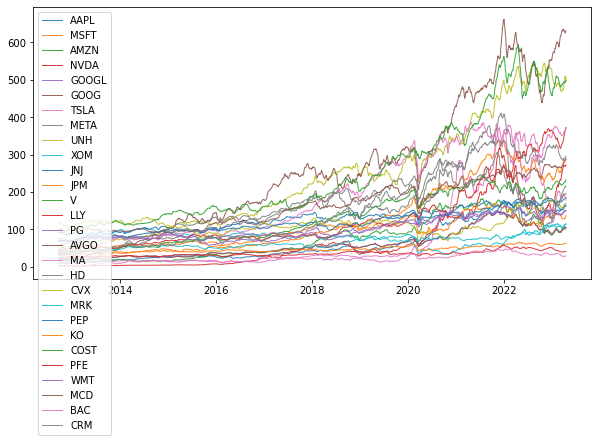

In [18]:
plot_stocks_columns(stocks_data,'Exponential_moving_average')
#plt.plot(stocks_data["AAPL"]['Exponential_moving_average'], linewidth=1, alpha=0.8, label="AAPL")

In [ ]:
#plot_stocks_columns(stocks_data,'MACD')

In [ ]:
#plot_stocks_columns(stocks_data,'CHIKOU')

In [ ]:
#plot_stocks_columns(stocks_data,'14 period RSI')

In [ ]:
#plot_stocks_columns(stocks_data,'14 period ATR')

In [ ]:
#plot_stocks_columns(stocks_data,'volume')

In [ ]:
#plot_stocks_columns(stocks_data,'OBV')

* Lets look at  the columns that are highly correlated. We will have a model built using only the columns that are not OR slightly correlated. For this again we will just focus on one stock for now and create a dropping list

In [19]:
def correlation_matrix_plot(corr_df):
    fig, ax = plt.subplots(figsize=(21,10))
    Mask = np.triu(corr_df)
    sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.columns,mask=Mask,\
                annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)
    #ax.grid(True)
    plt.title('Stocks Correlation')
    ticks = np.arange(0,9,1)
    #plt.show()

In [20]:
float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
#float_df = float_df.drop(['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER'\
#                          , 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a',\
#                         'SENKOU', 'CHIKOU'], axis=1)
float_df = float_df.drop(["Adj Close"], axis=1)
corr = float_df.corr()

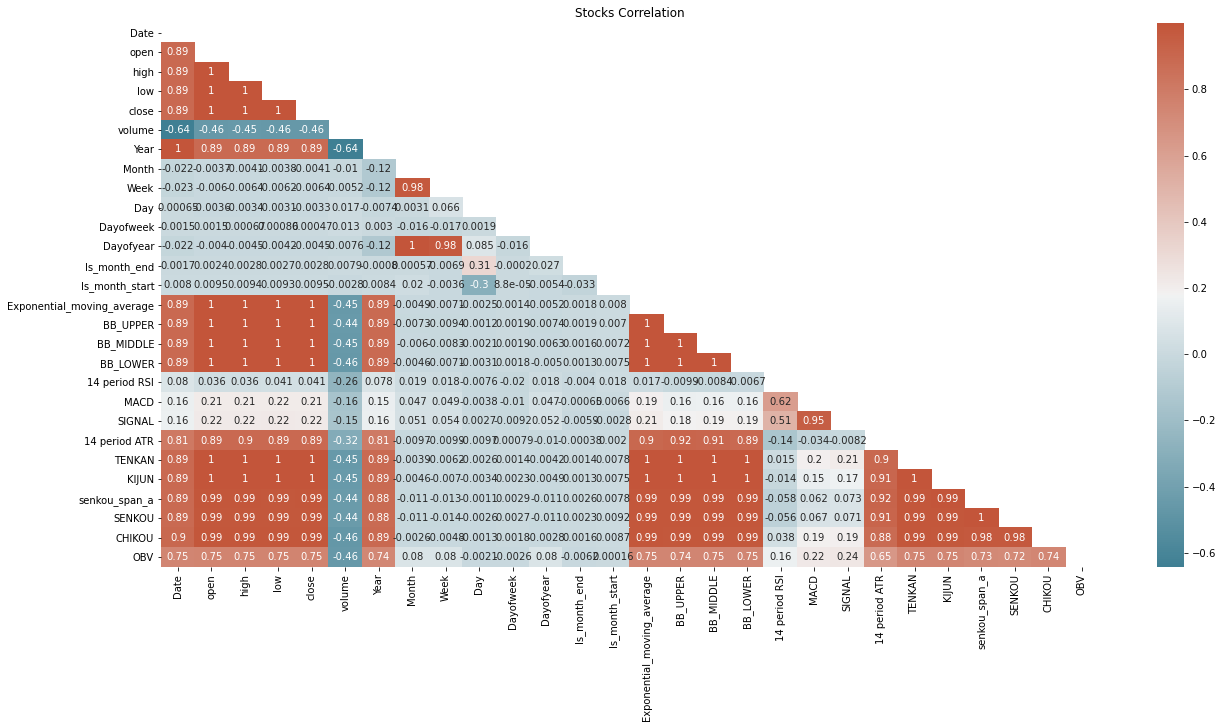

In [21]:
correlation_matrix_plot(corr)

In [22]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
#upper

In [ ]:
#print(to_drop)

In [ ]:
#(float_df.corr(method ='pearson'))

* Although its not an issue on run-time at this point even including all the columns. It can however quickly evolve into a time-consuming affair once we will have all the 500 companies included. So lets look at what PCA tells us about the number of variables that can suffice. 
* One can autoatize this part and make it stocks-specific to be included in a more advanced analysis

In [23]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=5)
pca_3 = PCA(n_components=6)

principalComponents = pca_1.fit_transform(corr)
principalComponents = pca_2.fit_transform(corr)
principalComponents = pca_3.fit_transform(corr)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9619046139610852
0.9849857008660812
0.9923903479100369


* Only 6 variables can be sufficient to achieve the same efficiency as with all the variables included

# Model Creation
### LONG SHORT-TERM MEMORY (LSTM) Model:  
(https://github.com/MohammadFneish7/Keras_LSTM_Diagram)
* We will attempt to use the Long Short-Term Memory (LSTM) model, a common deep learning recurrent neural network (RNN) used in predicting time series data. The diagram credit goes to (https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/)

<img src="./lstm_diagram.png" alt="LSTM" class="bg-primary" width="600px" height="600px">

* LSTM has logic gates (input, output and forget gates) which give inherent ability for it to retain information that is more relevant and forgo unnecessary information. This makes LSTM a good model for interpreting patterns over long periods.
* The important thing to note about LSTM is the input, which needs to be in the form of a 3D vector (samples, time-steps, features). Hence, the input has to be reshaped to fit this.

## TEST TRAIN Split:
* We will perform a train test split of 80:20, with a 10% reserved for validation data set
* **Adjusted Close** will be used as "y" i.e. the column that we want to predict.

In [ ]:
(stocks_data.keys())

In [24]:
TRAIN_SPLIT    = 0.8  # 80% of total dataset
VAL_TEST_SPLIT = 0.5  # 50% of the remaining dataset

total_count = len(stocks_data[list(stocks_data.keys())[0]])
train_count = int(total_count * TRAIN_SPLIT)
left = total_count - train_count
valid_count = int(left * VAL_TEST_SPLIT)
test_count = int(left - valid_count)

print(sum([train_count, valid_count, test_count]))
total_count, train_count, valid_count, test_count

2658


(2658, 2126, 266, 266)

* To make sure that all the stocks included here have similar number of entries

In [ ]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    print(i, ticker, len(df))

In [25]:
y_column = ['Adj Close']
cols_to_delete = ['Adj Close','Date','close']

In [26]:
#type(stocks_data)

* The cell below creates a train-test-validation split on all the stocks dataframes based on the %age we have defined above. We created a list of dictionaries for each stock with items as dataframes corresponding to train, test, validation sets

In [27]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    x_df = df.drop(columns=['Adj Close','Date'], axis=1)
    x_df = df.drop(cols_to_delete,axis=1)
    y_df = df[y_column]
    stocks_data[ticker] = {
        'x': x_df, 'y': y_df,
        'x_train': x_df[0:train_count], 'y_train': y_df[0:train_count],
        'x_valid': x_df[train_count:train_count+valid_count], 'y_valid': y_df[train_count:train_count+valid_count],
        'x_test': x_df[train_count+valid_count:], 'y_test': y_df[train_count+valid_count:],
    }

* Lets check to make sure that all the intended changes are there

### Create Time Series Generators
* **Keras** provides the **TimeseriesGenerator** that can be used to automatically transform a univariate or multivariate time series dataset into a **supervised learning problem**.

* There are two parts to using the TimeseriesGenerator: **defining it** and **using it** to train models.
* In addition to specifying the input and output aspects of your time series problem, there are some additional parameters that you should configure; for example:
    * **length**: The number of lag observations to use in the input portion of each sample (e.g. 3).
    * **batch_size**: The number of samples to return on each iteration (e.g. 32).
    
We must define a length argument based on designed framing of the problem. That is the desired number of lag observations to use as input.
we must also define the batch size as the batch size of our model during training. If the number of samples in teh dataset is less than batch size, one can set the batch size in the generator and in the model to the total number of samples in generator found via calculating its length.

In [28]:
#Import all the needed libs
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time

## Normalization of the Data
* Below we will normalize the data using MinMaxScalar. We will perform the scaling on the whole dataset and then transform train dataset and test dataset to scaled values 

In [32]:
for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_series = []
    y_series = []
    x_train_series = []
    y_train_series = []
    x_valid_series = []
    y_valid_series = []
    x_test_series = []
    y_test_series = []
    
    ds['x_values'] = ds['x'].values
    ds['y_values'] = ds['y'].values
    
    ds['x_train_values'] = ds['x_train'].values
    ds['y_train_values'] = ds['y_train'].values
    
    ds['x_valid_values'] = ds['x_valid'].values
    ds['y_valid_values'] = ds['y_valid'].values
    
    ds['x_test_values'] = ds['x_test'].values
    ds['y_test_values'] = ds['y_test'].values
    
    # Append values
    x_series.append(ds['x_values'])
    y_series.append(ds['y_values'])
    
    x_train_series.append(ds['x_train_values'])
    y_train_series.append(ds['y_train_values'])
    
    x_valid_series.append(ds['x_valid_values'])
    y_valid_series.append(ds['y_valid_values'])
    
    x_test_series.append(ds['x_test_values'])
    y_test_series.append(ds['y_test_values'])
    

    x_dataset = hstack(tuple(x_series))
    y_dataset = hstack(tuple(y_series))

    x_train_dataset = hstack(tuple(x_train_series))
    y_train_dataset = hstack(tuple(y_train_series))

    x_valid_dataset = hstack(tuple(x_valid_series))
    y_valid_dataset = hstack(tuple(y_valid_series))

    x_test_dataset = hstack(tuple(x_test_series))
    y_test_dataset = hstack(tuple(y_test_series))

    # fit scalers on full series
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_dataset = x_scaler.fit_transform(x_dataset)
    y_dataset = y_scaler.fit_transform(y_dataset)
    
    # Scale train and validation datasets
    x_train_dataset = x_scaler.transform(x_train_dataset)
    y_train_dataset = y_scaler.transform(y_train_dataset)

    x_valid_dataset = x_scaler.transform(x_valid_dataset)
    y_valid_dataset = y_scaler.transform(y_valid_dataset)

    x_test_dataset = x_scaler.transform(x_test_dataset)
    y_test_dataset = y_scaler.transform(y_test_dataset)
    
    ds['x_train_dataset'] = x_train_dataset
    ds['y_train_dataset'] = y_train_dataset
    
    ds['x_valid_dataset'] = x_valid_dataset
    ds['y_valid_dataset'] = y_valid_dataset
    
    ds['x_test_dataset'] = x_test_dataset
    ds['y_test_dataset'] = y_test_dataset
    
    # Store feature scalers
    ds['x_scaler'] = x_scaler
    ds['y_scaler'] = y_scaler
    
    #print('*' * 5 + 'Train shapes for ' + ticker)
    #print(x_train_dataset.shape, y_train_dataset.shape) 
    
    #print('*' * 5 + 'Validation shapes for ' + ticker)
    #print(x_valid_dataset.shape, y_valid_dataset.shape) 
    
    #print('*' * 5 + 'Test shapes for ' + ticker)
    #print(x_test_dataset.shape, y_test_dataset.shape) 

In [ ]:
stocks_data['AAPL'].keys()

In [ ]:
pd.DataFrame(stocks_data['AAPL']['x_train_dataset'])
#(stocks_data['AAPL']['y_scaler'])

* Here we will use the KERAS TimeSeriesGenerator to create train, test and validation sample. We are using a window length of 90 days for these samples

In [33]:
window_length = 90
BATCH_SIZE = int(window_length / 5)

for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_train_dataset = ds['x_train_dataset']
    y_train_dataset = ds['y_train_dataset']
    
    x_valid_dataset = ds['x_valid_dataset']
    y_valid_dataset = ds['y_valid_dataset']
    
    x_test_dataset = ds['x_test_dataset']
    y_test_dataset = ds['y_test_dataset']
    
    train_generator = TimeseriesGenerator(x_train_dataset, y_train_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Train samples for {}: {}'.format(ticker, len(train_generator)))

    valid_generator = TimeseriesGenerator(x_valid_dataset, y_valid_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Validation samples for {}: {}'.format(ticker, len(valid_generator)))

    test_generator = TimeseriesGenerator(x_test_dataset, y_test_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Test samples for {}: {}'.format(ticker, len(test_generator)))
    
    ds['train_generator'] = train_generator
    ds['valid_generator'] = valid_generator
    ds['test_generator'] = test_generator

Train samples for AAPL: 114
Validation samples for AAPL: 10
Test samples for AAPL: 10
Train samples for MSFT: 114
Validation samples for MSFT: 10
Test samples for MSFT: 9
Train samples for AMZN: 114
Validation samples for AMZN: 10
Test samples for AMZN: 10
Train samples for NVDA: 114
Validation samples for NVDA: 10
Test samples for NVDA: 10
Train samples for GOOGL: 114
Validation samples for GOOGL: 10
Test samples for GOOGL: 10
Train samples for GOOG: 114
Validation samples for GOOG: 10
Test samples for GOOG: 11
Train samples for TSLA: 114
Validation samples for TSLA: 10
Test samples for TSLA: 10
Train samples for META: 114
Validation samples for META: 10
Test samples for META: 10
Train samples for UNH: 114
Validation samples for UNH: 10
Test samples for UNH: 10
Train samples for XOM: 114
Validation samples for XOM: 10
Test samples for XOM: 10
Train samples for JNJ: 114
Validation samples for JNJ: 10
Test samples for JNJ: 10
Train samples for JPM: 114
Validation samples for JPM: 10
Tes

## Fit Stacked LSTM Model on Generator Data
* We chose 50 input layers, have added dropout and one additional layer with 50 units.
* We am also choosing an EarlyStopping parameter with *validation loss* as monitor parameter and a patiemce of 10.
* We will have to study the affect of other parameters like hyperparamter optimization such as learning rate and different optimizers.
* To check the model performnce, we will use **MAPE**, which is mean absolute percentage error.
* We will set the EPOCHS to 100.
* Also used is **TensorBoard**, which is a visualization tool provided with TensorFlow. This callback logs events for TensorBoard, including: Metrics summary plots, Training graph visualization, Weight histograms (https://keras.io/api/callbacks/tensorboard/#:~:text=TensorBoard%20is%20a%20visualization%20tool,Weight%20histograms).
* We will perform model fitting on all the 30 stocks that we started with.

In [ ]:
#print(stocks_data['AAPL'].columns)

In [34]:
EPOCHS = 100
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [tensorboard,early_stopping]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=0, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    #val_loss = model.evaluate_generator(valid_generator)
    #print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    #test_predict = model.predict_generator(test_generator)
    #predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    #predicted_df = predicted_df.rename(columns={0: ticker})
    
    #original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    #predicted_df.index = original_test.index
    
    #predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    
    #%matplotlib inline
    #plt.figure(figsize=(12, 8))

    #plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    #plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    #plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    #plt.savefig('plots/{}'.format(ticker))
    #plt.show()
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")

*****Training for AAPL
*****Training for MSFT
*****Training for AMZN
*****Training for NVDA
*****Training for GOOGL
*****Training for GOOG
*****Training for TSLA
*****Training for META
*****Training for UNH
*****Training for XOM
*****Training for JNJ
*****Training for JPM
*****Training for V
*****Training for LLY
*****Training for PG
*****Training for AVGO
*****Training for MA
*****Training for HD
*****Training for CVX
*****Training for MRK
*****Training for PEP
*****Training for KO
*****Training for COST
*****Training for PFE
*****Training for WMT
*****Training for MCD
*****Training for BAC
*****Training for CRM


In [ ]:
#model.history.history()
predicted_ticker

In [ ]:
len(stocks_data)

# Generating Final Data Frame for the Predicted Data
* We will now generate the predicted stocks distribution using the best models fit above 

Val loss for AAPL: 0.01956590823829174
Val loss for MSFT: 0.006351026706397533
Val loss for AMZN: 0.0022101178765296936
Val loss for NVDA: 0.08241456747055054
Val loss for GOOGL: 0.02309749647974968
Val loss for GOOG: 0.029287023469805717
Val loss for TSLA: 0.004207316320389509
Val loss for META: 0.018197666853666306
Val loss for UNH: 0.0039461166597902775
Val loss for XOM: 0.0024301917292177677
Val loss for JNJ: 0.0024134425912052393
Val loss for JPM: 0.0012154574505984783
Val loss for V: 0.0014576517278328538
Val loss for LLY: 0.019426586106419563
Val loss for PG: 0.007686692290008068
Val loss for AVGO: 0.004906097427010536
Val loss for MA: 0.006236419081687927
Val loss for HD: 0.04629272222518921
Val loss for CVX: 0.04740341752767563
Val loss for MRK: 0.0013342528836801648
Val loss for PEP: 0.016524143517017365
Val loss for KO: 0.022517599165439606
Val loss for COST: 0.020299788564443588
Val loss for PFE: 0.05264715105295181
Val loss for WMT: 0.0018449821509420872
Val loss for MCD: 

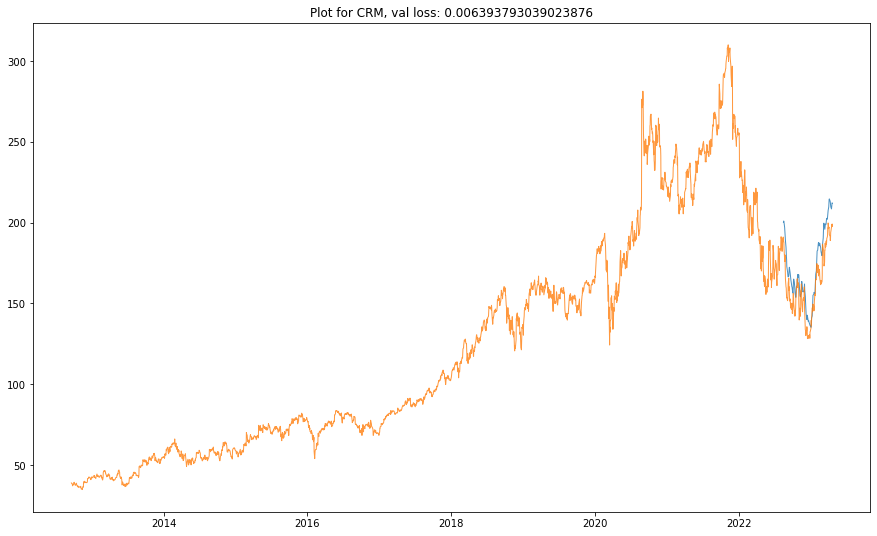

In [35]:
total_test_mape =0
total_train_mape =0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE*26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    test_acc = np.mean(mean_absolute_percentage_error(original_test,predicted_ticker[ticker]))
    
    train_predict = model.predict_generator(train_generator)
    train_predicted_df = pd.DataFrame(y_scaler.inverse_transform(train_predict))
    train_predicted_df = train_predicted_df.rename(columns={0: ticker})
    original_train = stocks_data[ticker]['y_train'].iloc[window_length:]
    train_predicted_df.index = original_train.index
    
    train_predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    train_acc = np.mean(mean_absolute_percentage_error(original_train,train_predicted_ticker[ticker]))
    
    total_train_mape+=train_acc
    total_test_mape+=test_acc
    
    %matplotlib inline
    plt.figure(figsize=(15, 9))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    #plt.plot(train_predicted_ticker[ticker], linewidth=1, alpha=0.8)
    #plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    #plt.show()
    #plot_model_performance(modelF,model,train_x,test_x,"accuracy", "val_accuracy")
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")
    train_loss = model.evaluate_generator(train_generator);
    test_loss  = model.evaluate_generator(test_generator);
    #print('--------------------------')
    #print(f'Final Train Loss: {np.round(train_loss,4)}')
    #print(f'Final Test Loss: {np.round(test_loss,4)}') 
    #print('--------------------------')
    #print(f'Final Train MAPE: {np.round(train_acc,4)}')
    #print(f'Final Test MAPE: {np.round(test_acc,4)}') 
    #print('\n')

In [36]:
print(f'Final MAPE score: Train={np.round(total_train_mape/len(stocks_data))}')
print(f'Final MAPE score: Test={np.round(total_test_mape/len(stocks_data))}')

Final MAPE score: Train=249.0
Final MAPE score: Test=16.0


## Write Predictions to a CSV File

In [37]:
count = 0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
#     val_loss = model.evaluate_generator(valid_generator)
#     print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    if count > 0:
        predicted_ticker = pd.concat([predicted_df[ticker], predicted_ticker], axis=1)
    else: 
        predicted_ticker = predicted_df[ticker]
        
    count += 1

In [38]:
predicted_ticker.to_csv('predicted_adj_close_50.csv')

## Build RETURNS Dataframe to Predict Portfolios:
* We will use PANDAS pct_change method to build returns. This method basically returns the difference of value to the previous value

In [40]:
data = pd.read_csv('predicted_adj_close_50.csv')
data.index = data['Date']
data = data.drop(['Date'],axis=1)
data = data.sort_index(ascending=True, axis=0)
#data = data.iloc[0:91]
returns = data.pct_change()[1:]
#returns

In [42]:
#returns.isna().sum()

In [43]:
Covariance = returns.cov()
Correlation = returns.corr()
np.round(Correlation,3)

,CRM,BAC,MCD,WMT,PFE,COST,KO,PEP,MRK,CVX,...,XOM,UNH,META,TSLA,GOOG,GOOGL,NVDA,AMZN,MSFT,AAPL
CRM,1.000,0.456,0.306,0.259,0.078,0.181,0.135,0.368,-0.118,0.298,...,0.145,0.108,0.568,0.454,0.587,0.641,0.268,0.627,0.562,0.587
BAC,0.456,1.000,0.325,0.265,0.300,0.025,0.273,0.429,0.136,0.551,...,0.200,0.293,0.205,0.377,0.293,0.434,0.168,0.146,0.429,0.417
MCD,0.306,0.325,1.000,0.560,0.645,0.333,0.498,0.646,0.071,0.489,...,0.060,0.441,-0.014,0.451,0.293,0.362,0.513,0.338,0.017,0.528
WMT,0.259,0.265,0.560,1.000,0.693,0.146,0.496,0.793,-0.249,0.561,...,-0.090,0.429,0.212,0.669,0.502,0.461,0.816,0.514,0.138,0.609
PFE,0.078,0.300,0.645,0.693,1.000,0.256,0.600,0.783,0.149,0.516,...,0.003,0.664,-0.095,0.455,0.276,0.291,0.649,0.188,0.169,0.506
COST,0.181,0.025,0.333,0.146,0.256,1.000,-0.064,0.103,0.446,0.038,...,0.396,0.300,-0.096,-0.106,-0.026,-0.022,0.155,0.233,-0.152,0.205
KO,0.135,0.273,0.498,0.496,0.600,-0.064,1.000,0.591,-0.056,0.424,...,-0.031,0.366,0.135,0.281,0.342,0.344,0.553,0.109,0.235,0.402
PEP,0.368,0.429,0.646,0.793,0.783,0.103,0.591,1.000,-0.055,0.550,...,-0.068,0.548,0.206,0.732,0.453,0.529,0.674,0.471,0.354,0.694
MRK,-0.118,0.136,0.071,-0.249,0.149,0.446,-0.056,-0.055,1.000,0.019,...,0.359,0.487,-0.232,-0.376,-0.259,-0.142,-0.172,-0.406,0.116,-0.020
CVX,0.298,0.551,0.489,0.561,0.516,0.038,0.424,0.550,0.019,1.000,...,0.271,0.442,0.205,0.404,0.414,0.432,0.430,0.262,0.254,0.353


In [ ]:
Covariance

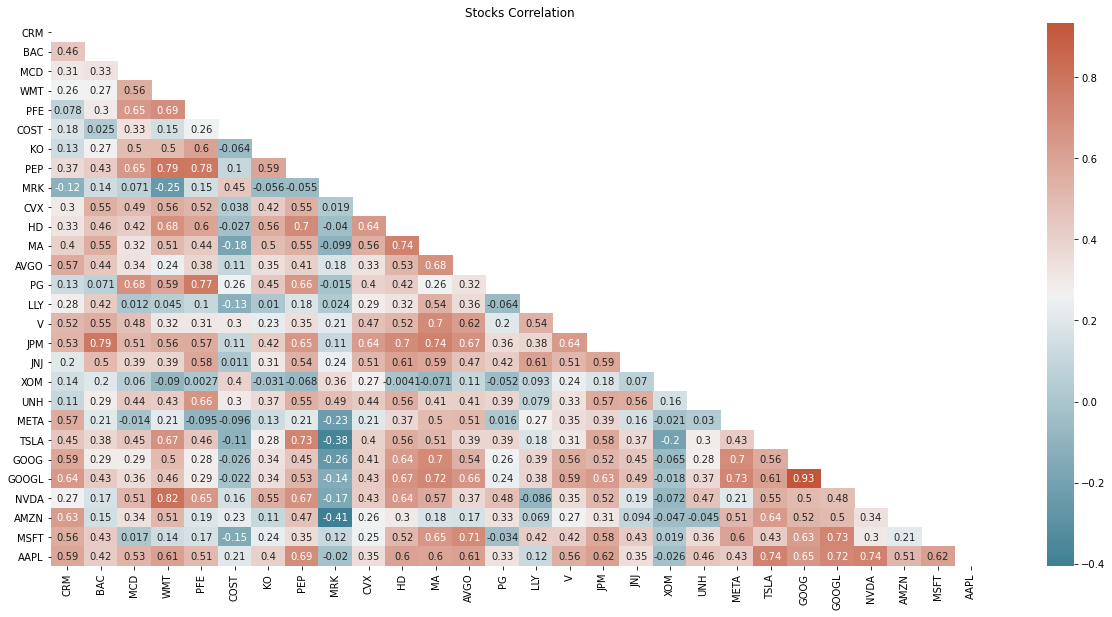

In [44]:
correlation_matrix_plot(Correlation)

In [46]:
companies = SP500_top30[0:28]#['AAPL', 'MSFT', 'META', 'TSLA', 'UNH', 'GOOGL']
mean_Covariance = Covariance.mean()
#mean_Covariance

### Check if a particular pair of stock can be paired together
* If a pair of stock meets both Covariance and correlation thresholds then they can be paired together. The plot below shows pairable stocks in blue and unpairable ones in red.

In [166]:
def get_pairable(data, Covariance, Correlation):
    Pairable = np.zeros(Covariance.shape)
    plt.figure(figsize=(16,7))

    for i in range(len(companies)):
        for j in range(len(companies)-i):
            if((Covariance[i,j] > mean_Covariance[i])\
               or (Covariance[i,j] > mean_Covariance[j])\
               or Correlation[i][j]>0.5):
                plt.plot(i, j, 'o', color='red', alpha=0.5) 
            else:
                plt.plot(i, j, 'o', color='blue', alpha=0.5)
                Pairable[i,j] = 1

    plt.xlim(-1,len(companies)+1)
    plt.ylim(-1,len(companies)+1)
    plt.xticks(range(len(companies)), companies, rotation=40)    
    plt.yticks(range(len(companies)), companies)
    plt.legend(['Not Pairable'], loc='upper right', fontsize=15)
    #plt.set_xticklabels(companies,fontsize=10,rotation=40)
    #plt.legend()
    plt.show()
    plt.savefig("./figures/pairable_stocks.png")
    return Pairable

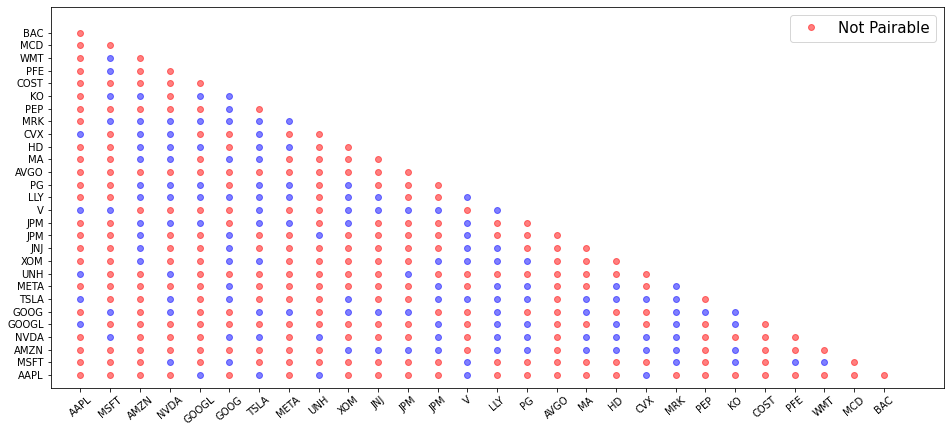

<Figure size 432x288 with 0 Axes>

In [167]:
Pairable = get_pairable(data,np.array(Covariance), np.array(Correlation))

In [50]:
#Pairable

##  Risk-Adjusted Returns
The **Sharpe ratio**—also known as the modified Sharpe ratio or the Sharpe index—is a way to measure the performance of an investment by taking risk into account. It can be used to evaluate a single security or an entire investment portfolio. In either case, the higher the ratio, the better the investment in terms of risk-adjusted returns.

The Sharpe Ratio is calculated by determining an asset or a portfolio’s “excess return” for a given period of time. This amount is divided by the portfolio’s standard deviation, which is a measure of its volatility. To calculate the Sharpe Ratio, use this formula:

        * Sharpe Ratio = (Rp – Rf) / Standard deviation
**Rp**: return of portfolio/mean return

**Rf**: risk-free rate of 3.7% ie current risk free rate of US market

**Standard Deviation**: standard deviation of the portfolio’s excess return

**Sharpe ratio > 1** is considered **good**

**Sharpe ratio > 2** is considered **very good**

**Sharpe ratio > 3** is considered **excellent**

*Limitations:* Sharpe ratio assumes that an investment’s average returns are normally distributed on a curve.Unfortunately, normal distributions don’t represent the real world of financial markets very well. Over the short term, investment returns don’t follow a normal distribution. Market volatility can be higher or lower, while the distribution of returns on a curve cluster around the tails. This can render standard deviation less effective as a measure of risk.


In [119]:
# Function to calculate the Shapre Ratio
Rf = 0/100;#3.7/100  #risk_free_rate
stocks_rng = range(len(companies))

def sharpe_ratio(pair, portfolio_weights, meanR, cov):
    #print("SR",pair,portfolio_weights, meanR, cov)
    #print (meanR.T)
    Rp = portfolio_weights.dot(meanR.T) 
    SigmaP = portfolio_weights.dot(cov.dot(portfolio_weights.T)) * len(returns)
    s_ratio = (Rp - Rf)/np.sqrt(SigmaP)
    #print (s_ratio)#, Rp, SigmaP, Rf)
    return s_ratio


In [111]:
stocks_rng

range(0, 28)

**Checking whether other stocks can be added to selected pair**
* Only those pairs are selected in a portfolio that are not correlated with each other.

In [91]:
def check_pairs(pair):
    not_in_pair = []
    for i in stocks_rng:
        if(i not in pair):
            not_in_pair.append(i)
        else:
            continue
            
    for tick in not_in_pair:
        total_pair = len(pair)
        for i in pair:
            if(Pairable[tick,i]!=1 or Pairable[i,tick]!=1):
                total_pair -= 1
        if(float(total_pair)/len(pair) > 0.5):
            pair.add(tick)              
    return pair

* Just some checks to see what the covariance and correlations 

In [120]:
#symbols = [companies[s] for s in pair] 
symbols =['AAPL', 'MSFT', 'GOOGL', 'META']
len(returns)
returns[symbols[3]].mean()*len(returns)
returns[symbols].cov()

,AAPL,MSFT,GOOGL,META
AAPL,0.000017,0.000015,0.000024,0.000019
MSFT,0.000015,0.000033,0.000035,0.000037
GOOGL,0.000024,0.000035,0.000066,0.000063
META,0.000019,0.000037,0.000063,0.000111


Analyzing returns for:  AAPL


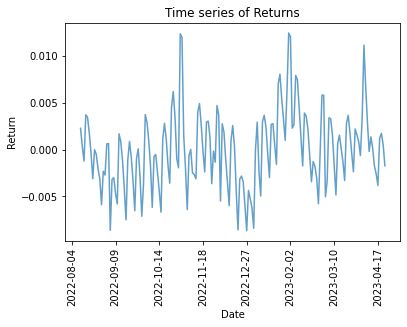

In [121]:
ticker = companies[0]
print("Analyzing returns for: ", ticker)
plt.title('Time series of Returns')
returns[ticker].plot(alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Return")
plt.show()

### Selecting Optimized Portfolios
We create all possible combinations of pairs in given list of tickers. For example if we have **n** tickers, then possible pairs will be **C(n,2)= n!/(2!*(n-2)!)**

* For each pair, we then check which other stock can be added together by checking it's correlation and covariance values, and they are added in same portfolio.

* Portfolis with good, better, best Sharpe Ratio are saved separately.

In [122]:
portfolio_collection = []
optim = {'good':[],'better':[],'best': []}

def select(combo):
    pair = set(combo)
    pair = check_pairs(pair)
    #print("new pair by checking pairable: ", pair)
    if pair in portfolio_collection:
        #print('returning')
        return
    portfolio_collection.append(pair)
    #print("portfoilio: ", portfolio_collection)
    sharpe_r = 0
    eff_weights = np.ones(len(pair))

    symbols = [companies[s] for s in pair]  
    mean_returns = np.array(returns[symbols].mean()) * len(returns)
    sub_cov_mat = np.array(returns[symbols].cov())        
    #print(symbols)#, mean_returns, sub_cov_mat)
    for _ in range(10):
        weights = [np.random.randint(50,500) for _ in pair]
        weights = np.array(weights, dtype=float)
        weights /= weights.sum()
        s_r = sharpe_ratio(pair, weights, mean_returns, sub_cov_mat)
        #print(pair)
        #print(weights)
        #print(mean_returns)
        #print(sub_cov_mat)
        if( s_r > sharpe_r):
            sharpe_r = s_r
            eff_weights = weights
        
    if (sharpe_r >= 1 and sharpe_r < 2) :
        optim['good'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if (sharpe_r >= 2 and sharpe_r < 3) :
        optim['better'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if(sharpe_r >=3) :
        optim['best'].append([[companies[s] for s in pair],eff_weights,sharpe_r])

In [115]:
#(returns["MSFT"].mean())/returns["MSFT"].std()

* Make stocks combinations with each pair containing 2 stocks and rest of the stocks to be added later

In [123]:
from itertools import combinations
count=0
run = list(combinations(stocks_rng,2))
for combo in run:
    count +=1
    if(Pairable[combo[0],combo[1]]!=1 or Pairable[combo[1],combo[0]]!=1):
        continue
    else:
        #print("taking the combo")
        #print(combo)
        select(combo)
#print("number of combinations: ", count)

In [117]:
#portfolio_collection

### Look at DataFrame for Good Portfolios

In [124]:
good = pd.DataFrame.from_dict(optim['good'])
good.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [125]:
def build_portfolio_return(df_ret):
    portfolio_return = []
    for row in df_ret.iterrows():
        print(row[1][0])
        print(row[1][1])
        mean = np.array(returns[row[1][0]].mean()) * len(returns)
        portfolio_weights = np.array(row[1][1])
        Rp = portfolio_weights.dot(mean.T) 
        portfolio_return.append(round(Rp * 100, 2))
        #print('Rp:', Rp)
    return portfolio_return

In [126]:
good['Portfolio_Returns'] = build_portfolio_return(good)

['MSFT', 'V']
[0.18783069 0.81216931]
['MSFT', 'NVDA', 'GOOG', 'TSLA', 'LLY', 'MRK']
[0.05172414 0.19715142 0.13943028 0.06146927 0.33283358 0.2173913 ]
['MSFT', 'MRK', 'GOOG', 'KO']
[0.17986425 0.4061086  0.23868778 0.17533937]
['AMZN', 'XOM', 'JPM', 'V', 'LLY']
[0.06519559 0.24573721 0.2337011  0.37713139 0.0782347 ]
['AMZN', 'XOM', 'JNJ', 'V', 'LLY']
[0.06464088 0.15248619 0.26685083 0.24088398 0.27513812]
['XOM', 'AMZN', 'JPM', 'PG']
[0.44033791 0.06335797 0.17845829 0.31784583]
['NVDA', 'TSLA', 'XOM', 'JPM', 'V', 'LLY']
[0.19816514 0.05259939 0.2648318  0.11926606 0.1883792  0.17675841]
['NVDA', 'TSLA', 'XOM', 'JPM', 'V', 'LLY', 'PG']
[0.18213457 0.03190255 0.15139211 0.112529   0.26044084 0.17575406
 0.08584687]
['GOOGL', 'JPM']
[0.14716312 0.85283688]
['GOOGL', 'LLY']
[0.30758226 0.69241774]
['GOOGL', 'MRK']
[0.20320856 0.79679144]
['JNJ', 'GOOG', 'LLY']
[0.29069767 0.09883721 0.61046512]
['JPM', 'GOOG']
[0.83547009 0.16452991]
['MSFT', 'NVDA', 'GOOG', 'MRK', 'KO']
[0.12376238 0

In [127]:
def build_portfolio_voltality(df_ret):
    portfolio_volatility = []
    for row in df_ret.iterrows():
        portfolio = row[1][0]
        portfolio_weights = row[1][1]
        portfolio_data = data[portfolio]
        portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
        volatility = np.std(portfolio)
        portfolio_volatility.append(volatility)
    return portfolio_volatility

In [128]:
good['Portfolio_Volatility'] = build_portfolio_voltality(good)
#good

In [129]:
optim['better']

[[['MRK', 'GOOG', 'LLY', 'META'],
  array([0.30363036, 0.08690869, 0.51155116, 0.09790979]),
  2.310455617649722]]

In [130]:
better = pd.DataFrame.from_dict(optim['better'])
better.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [131]:
better['Portfolio_Returns'] = build_portfolio_return(better)
better['Portfolio_Volatility'] = build_portfolio_voltality(better)

['MRK', 'GOOG', 'LLY', 'META']
[0.30363036 0.08690869 0.51155116 0.09790979]


In [132]:
better

,Portfolio,Weights,Sharpe Ratio,Portfolio_Returns,Portfolio_Volatility
0,"[MRK, GOOG, LLY, META]","[0.30363036303630364, 0.08690869086908691, 0.5115511551155115, 0.09790979097909791]",2.310456,10.24,39.110893


In [106]:
#train_generator
#stocks_data['AAPL'].items()

In [107]:
#Defining MAPE function
#def MAPE(Y_actual,Y_Predicted):
#    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
#    return mape


# LSTM Model to Predict Future (30 days ahead)

In [109]:
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(LSTM(50, activation='relu'))
EPOCHS = 100
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 30
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
    checkpoint = ModelCheckpoint(filepath, save_best_only=True)
    callbacks_list = [tensorboard,early_stopping,checkpoint]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=0, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    #test_predict = model.predict_generator(test_generator)
    #predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    #predicted_df = predicted_df.rename(columns={0: ticker})
    #original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    #predicted_df.index = original_test.index
    #predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    

*****Training for AAPL
Val loss for AAPL: [0.02603539638221264, 16.35364532470703]
*****Training for MSFT
Val loss for MSFT: [0.022443844005465508, 14.348746299743652]
*****Training for AMZN
Val loss for AMZN: [0.0031267984304577112, 5.564538478851318]
*****Training for NVDA
Val loss for NVDA: [0.09537124633789062, 37.8000373840332]
*****Training for GOOGL
Val loss for GOOGL: [0.020294245332479477, 14.907240867614746]
*****Training for GOOG
Val loss for GOOG: [0.008612297475337982, 9.255122184753418]
*****Training for TSLA
Val loss for TSLA: [0.030418382957577705, 17.70839500427246]
*****Training for META
Val loss for META: [0.02112545818090439, 17.828746795654297]
*****Training for UNH
Val loss for UNH: [0.02246425859630108, 17.647890090942383]
*****Training for XOM
Val loss for XOM: [0.002428715815767646, 7.185137748718262]
*****Training for JNJ
Val loss for JNJ: [0.0013533676974475384, 3.7614777088165283]
*****Training for JPM
Val loss for JPM: [0.002113841939717531, 4.3784880638122

In [ ]:
#model.summary()

## Generate Predictions for Next 30 Days:
* We are just showing predictions for one stock for now.

In [133]:
stocks_data["AAPL"].keys()

dict_keys(['x', 'y', 'x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test', 'x_values', 'y_values', 'x_train_values', 'y_train_values', 'x_valid_values', 'y_valid_values', 'x_test_values', 'y_test_values', 'x_train_dataset', 'y_train_dataset', 'x_valid_dataset', 'y_valid_dataset', 'x_test_dataset', 'y_test_dataset', 'x_scaler', 'y_scaler', 'train_generator', 'valid_generator', 'test_generator'])

Text(0.5, 1.0, 'Future Prediction Plot for GOOG ')

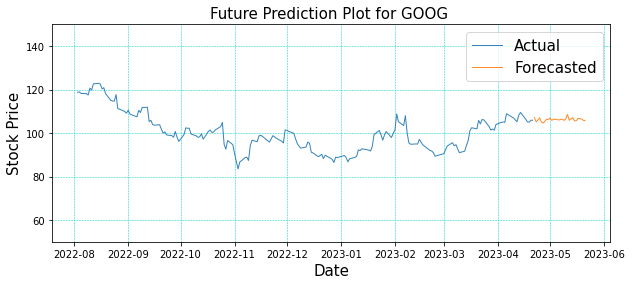

In [153]:
# Make test predictions
ticker ="GOOG"
train_generator = stocks_data[ticker]['train_generator']
valid_generator = stocks_data[ticker]['valid_generator']
test_generator = stocks_data[ticker]['test_generator']
x_scaler = stocks_data[ticker]['x_scaler']
y_scaler = stocks_data[ticker]['y_scaler']

filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
OUTPUT_SIZE = 30
    
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, 26)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(OUTPUT_SIZE))
    
model.load_weights(filepath)

model.compile(loss='mean_squared_error', optimizer='adam')
test_predict = model.predict_generator(test_generator)
Y_ = y_scaler.inverse_transform(test_predict)
predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
predicted_df = predicted_df.rename(columns={0: ticker})
    
original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
predicted_df.index = original_test.index
    
predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)

#predicted_ticker

df_past = predicted_ticker['Adj Close'].reset_index()
#df_past = original_test['Adj Close'].reset_index()

df_past.rename(columns={'index': 'Date', 'Adj Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
df_future['Forecast'] = Y_[-1].flatten()
df_future['Actual'] = np.nan
df_future

list_df = [df_past,df_future]
results = pd.concat(list_df).set_index('Date')
#([predicted_df[ticker], original_test], axis=1)
# plot the results
#results.plot()

plt.figure(figsize=(10, 4))
#plt.grid(True)
plt.grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)

#plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
#plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
#plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
#plt.plot(results)
plt.plot(results['Actual'], linewidth=1, alpha=0.9,label="Actual")
plt.plot(results['Forecast'], linewidth=1, alpha=0.9,label="Forecasted")
plt.ylabel("Stock Price",fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.legend(fontsize=15)
plt.ylim(50, 150)
plt.savefig('figures/future_{}.png'.format(ticker))
plt.title('Future Prediction Plot for {} '.format(ticker.upper()),fontsize=15)

In [137]:
#stocks_data[ticker]['y_test'].iloc[90:]
#results

,Actual,Forecast
Date,,
2022-08-03,118.779999,NaN
2022-08-04,118.870003,NaN
2022-08-05,118.220001,NaN
2022-08-08,118.139999,NaN
2022-08-09,117.500000,NaN
...,...,...
2023-05-17,NaN,106.779541
2023-05-18,NaN,106.632156
2023-05-19,NaN,106.506599


In [ ]:
#model.summary()

In [154]:
def get_ticker_volatility(portfolio):
    tick_std = np.std(data[portfolio])
    print(tick_std)

In [155]:
get_ticker_volatility(good['Portfolio'][8])

GOOGL     6.621653
JPM      10.544315
dtype: float64


In [156]:
print(good['Portfolio_Volatility'][8],good['Portfolio_Returns'][8])

30.34676441751618 15.44


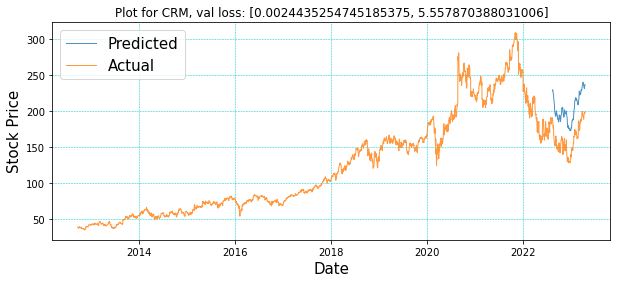

In [163]:
total_test_mape =0
total_train_mape =0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 30

    
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True, input_shape=(window_length, 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    
    #val_loss, mape_val = model.evaluate_generator(valid_generator)
    #print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    test_acc = np.mean(mean_absolute_percentage_error(original_test,predicted_ticker[ticker]))
    
    train_predict = model.predict_generator(train_generator)
    train_predicted_df = pd.DataFrame(y_scaler.inverse_transform(train_predict))
    train_predicted_df = train_predicted_df.rename(columns={0: ticker})
    original_train = stocks_data[ticker]['y_train'].iloc[window_length:]
    train_predicted_df.index = original_train.index
    
    train_predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    train_acc = np.mean(mean_absolute_percentage_error(original_train,train_predicted_ticker[ticker]))
    
    total_train_mape+=train_acc
    total_test_mape+=test_acc
    
    %matplotlib inline
    plt.figure(figsize=(10, 4))
    plt.grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)
    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8,label="Predicted")
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8,label="Actual")
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.legend(fontsize=15)
    plt.ylabel("Stock Price",fontsize=15)
    plt.xlabel("Date",fontsize=15)
    plt.savefig('plots/{}'.format(ticker))
    #plt.show()
    
    train_loss = model.evaluate_generator(train_generator);
    test_loss  = model.evaluate_generator(test_generator);
    #print('--------------------------')
    #print(f'Final Train Loss: {np.round(train_loss,4)}')
    #print(f'Final Test Loss: {np.round(test_loss,4)}') 
    #print('--------------------------')
    #print(f'Final Train MAPE: {np.round(train_acc,4)}')
    #print(f'Final Test MAPE: {np.round(test_acc,4)}') 
    #print('\n')

In [160]:
print(f'Final MAPE score: Train={np.round(total_train_mape/len(stocks_data))}')
print(f'Final MAPE score: Test={np.round(total_test_mape/len(stocks_data))}')

Final MAPE score: Train=230.0
Final MAPE score: Test=18.0


# Conclusions
* We have built a basic framework:
    * fits LSTM models on all the stocks that are included in study.
    * build Returns for each individual stocks.
    * predicts combinations of stocks to build profitable portfolios based on Shapre Ratio and Voltality.
    
## Future Improvements
* Check other models such as GARCH, Random Forests etc to get prediction for stocks movement.
* Hyperparameter tuning of Models.
* Explore the models by including few variables versus all the variables that are included in this study.
* Include the sentienet analysis which includes web-carpping for news.
* Also implement the information from SEC reports submitted by companies.
